### ASTR 324, University of Washington


# Week 5.2: Bayesian Model Selection



## Model Selection

We've fit a straight line to our data; but **what if we have a competing model?**

For example, how do we know that we should fit a straight line to our data and not, perhaps, 
a parabola, or y=sin(x), etc? 
  

In [1]:
## Let's use Jake's excellent example from
## http://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # set default plot styles
from scipy import stats
from scipy import optimize

# this function computes polynomial models given some data x
# and parameters theta
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(degree, data, model=polynomial_fit):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, data, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

CHI2:
   best linear model: 11.324128378349815
best quadratic model: 9.462835218566871
    best cubic model: 8.99360837038816
CHI2 per degree of freedom:
   best linear model: 0.6291182432416564
best quadratic model: 0.5566373657980512
    best cubic model: 0.56210052314926


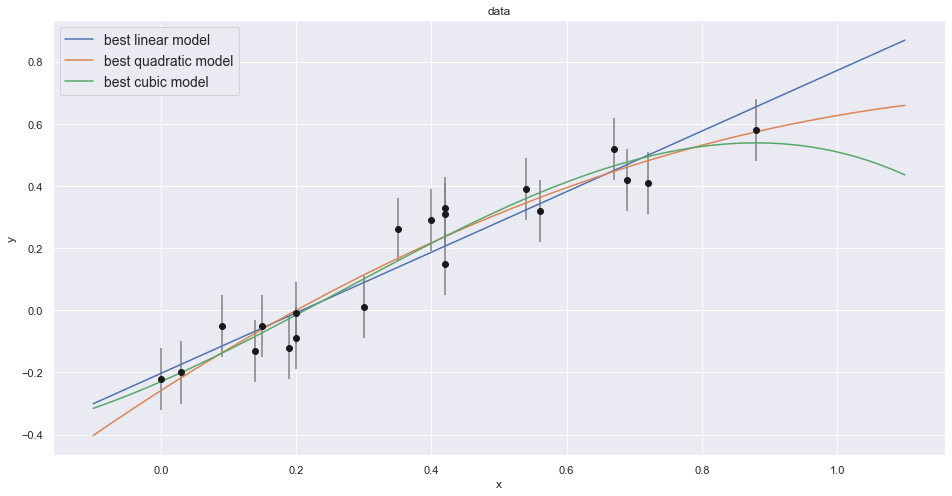

In [2]:
# generate (x,y, sigma_y) "data" 
data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.22,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39, 
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])
x, y, sigma_y = data
Ndata = x.size

# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(1, data=data)
theta2 = best_theta(2, data=data)
theta3 = best_theta(3, data=data)
# generate best fit lines on a fine grid 
xfit = np.linspace(-0.1, 1.1, 1000)
yfit1 = polynomial_fit(theta1, xfit)
yfit2 = polynomial_fit(theta2, xfit)
yfit3 = polynomial_fit(theta3, xfit)
# and compute chi2 per degree of freedom: sum{[(y-yfit)/sigma_y]^2} 
chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) 
chi22 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) 
chi23 = np.sum(((y-polynomial_fit(theta3, x))/sigma_y)**2) 
# the number of fitted parameters is 2, 3, 4
chi2dof1 = chi21/(Ndata - 2)
chi2dof2 = chi22/(Ndata - 3)
chi2dof3 = chi23/(Ndata - 4)

print("CHI2:")
print('   best linear model:', chi21)
print('best quadratic model:', chi22)
print('    best cubic model:', chi23)
print("CHI2 per degree of freedom:")
print('   best linear model:', chi2dof1)
print('best quadratic model:', chi2dof2)
print('    best cubic model:', chi2dof3)

# plot 
fig, ax = plt.subplots(figsize=(16, 8))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xfit, polynomial_fit(theta1, xfit), label='best linear model')
ax.plot(xfit, polynomial_fit(theta2, xfit), label='best quadratic model')
ax.plot(xfit, polynomial_fit(theta3, xfit), label='best cubic model')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');


$\chi^2$ per degree of freedom was computed as 

$$ \chi^2_{dof}  = \frac{1}{N-k} \sum_i^N \left( \frac{y - y_{fit}}{\sigma_y} \right)^2, $$

where $N$ is the number of data points and $k$ is the number of free model parameters (2, 3, and 4).

For large values of $(N-k)$ (larger than about 10), the distribution of 
$\chi^2$ per degre of freedom is approximately Gaussian centered on $\mu=1$ and the width of
$\sigma=\sqrt{2/(N-k)}$  (here, $\sigma = 0.33, 0.34, 0.35$). 

The values of $\chi^2$ per degre of freedom for the three models are: 

   best linear model: 0.629 

best quadratic model: 0.557

best cubic model: 0.562 

 
**Which model should we adopt?**

Obviously, the cubic model has the lowest $\chi^2$ ("fits the best"), but 
it has 4 free parameters while the linear model has only 2 free parameters.

**How do we trade improvement in $\chi^2$ with increasing model
complexity?**

**Occam’s razor:** select the simplest model that is in fair agreement with the data. This sounds reasonable, but can we understand why?

### Bayesian Model Comparison: Odds Ratio

That leads us to a discussion of model comparison (see textbook $\S$5.4 and $\S$5.7.1-3). To determine which model is better we compute the ratio of the posterior probabilities or the **odds ratio** for two models as

$$O_{21} \equiv \frac{p(M_2|D,I)}{p(M_1|D,I)}.$$

This is the ratio of probabilities that models $M_2$ and $M_1$ are correct, given the observed data $D$ and prior information $I$.

### Bayesian Model Comparison: Bayes Factor

As the posterior probability that the model $M$ is correct given data $D$ is

$$p(M\,|\,D,I) = \frac{p(D\,|\,M,I)p(M\,|\,I)}{p(D\,|\,I)},$$

we can write:

$$O_{21} = \frac{p(D\,|\,M_2,I)\,p(M_2\,|\,I)}{p(D\,|\,M_1,I)\,p(M_1\,|\,I)} \equiv B_{21} \, \frac{p(M_2\,|\,I)}{p(M_1\,|\,I)},$$

where $B_{21}$ is called the **Bayes factor**. Note how $p(D|I)$ cancels out, since it's the same for both models.

The Bayes factor compares how well the models fit the data: it is a ratio of data likelihoods averaged over 
all allowed values of the model parameters; if two models fit the data equally well, the "winner" is decided based on priors. For example, consider a noisy image of a source which is equally likely to be a star or a galaxy. 
The posterior probability that the source is a star will greatly depend on whether we are looking 
at the Galactic plane or not!

How do we evaluate $p(D\,|\,M,I)$?

We start with conditional probability:

$$ p(\theta, D, M, I) = p(\theta \,|\, D, M, I) \,p(D, M, I) = p(D \,|\, \theta, M, I) \,p( \theta, M, I) $$

... and more conditional probability:

$$ p(\theta \,|\, D, M, I) \,p(D \,|\, M, I) \,p(M, I) = p(D \,|\, \theta, M, I) p( \theta \,|\, M, I) \,p(M, I) $$

cancel out $p(M, I)$ and then integrate (a.k.a "marginalize") over the model parameter space $\theta$:

$$ p(D \,|\, M, I) \int p(\theta \,|\, D, M, I)\,d\theta = \int p(D \,|\, \theta, M, I)\,p( \theta \,|\, M, I)\,d\theta $$

and once we notice that that the integral to the left sums up to 1, we're left with:

$$ p(D\,|\,M, I) = \int p(D\,|\,M, \theta, I) \, p(\theta\,|\,M, I) \, d\theta, $$

(note we could have started with the Bayes theorem, saving us $\sim$one line of math; I personally find starting with conditional probability less confusing and error-prone)

## Evidence

The expression we've obtained:

$$ E(M) \equiv p(D\,|\,M, I) = \int p(D\,|\,M, \theta, I) \, p(\theta\,|\,M, I) \, d\theta, $$

is called **the marginal likelihood for model $M$** and it quantifies the probability that the 
data $D$ would be observed if the model $M$ were the correct model. It's the denominator when writing out the Bayes theorem for a given model and prior information:

$$ p(\theta \,|\, D, M, I) = \frac{p(D \,|\, \theta, M, I) \, p( \theta \,|\, M, I)}{p(D \,|\, M, I)} $$

In the physics literature, the marginal likelihood $E(M)$ is often called **evidence** (despite the fact that to 
scientists, evidence and data mean essentially the same thing). 
Since the evidence $E(M)$ involves integration of the data likelihood $p(D|M,\theta,I)$, it is also 
called **the global likelihood for model M**. It's a weighted average 
of the likelihood function, with the prior for model parameters acting as the weighting function.

## Example

The following plot shows the likelihood $p(D|M, \theta, I)$ for a sample drawn from Gaussian distribution (i.e., $\theta$ represents the pair of parameters $\{\mu, \sigma\}$). 

![BayesSlide1](figures/Lgauss.jpg)

The evidence for model $M={\rm Gauss}$ is found by **integrating** (summing up) this image over $\mu$ and $\sigma$.

If we think that the sample might have been drawn from some other distribution, we can produce an analogous
$p(D|M, \theta, I)$, say for $M={\rm Cauchy}$ ([here is an example](http://www.astroml.org/book_figures/chapter5/fig_likelihood_cauchy.html)),
integrate it, and compute the Bayes factor, and the models odds
ratio (with models assigned equal prior probabilities unless there is a reason that one model is more 
likely than another, e.g. recall the star/galaxy case) 

## How do we interpret the values of the odds ratio in practice?

Jeffreys proposed a five-step scale for interpreting the odds ratio, where $O_{21} > 10$ represents “strong” evidence in favor of $M_2$ ($M_2$ is ten times more probable than $M_1$), and $O_{21} > 100$ is “decisive” evidence ($M_2$ is one hundred times more probable than $M_1$). When $O_{21} < 3$, the evidence is “not worth more than a bare mention.”

But note:
  * These are just **definitions of conventions**, i.e., a way to give a quantitative meaning to qualitative phrases.
  * The odds ratio **compares** the models, it doesn't tell us about the *absolute* goodness of fit: model A can be 100x better than model B, but still be pretty lousy.
  
The thresholds ultimately depend on what action you plan to take given the evidence.

If the competing models are "the plane will survive given this design" and "the plane will crash given this design", you'll probably want to set a very high threshold on the odds ratio (see: Administration, Federal Aviation; CC: The Boeing Company).

### Sidenote: Bayesian Hypothesis Testing

In *hypothesis testing* we are essentially comparing a model, $M_1$, to its complement. That is $p(M_1) + p(M_2) = 1$.  

If we take $M_1$ to be the "null" (default) hypothesis (which is generally that, for example, a correlation does *not* exist), then we are asking whether or not the data reject the null hypothesis.

In classical hypothesis testing we can ask whether or not a single model provides a good description of the data.  

** In Bayesian hypothesis testing, we must have an alternative comparison model! **

## Bayesian Model Comparison: Example

Let's draw increasingly larger sample from a Cauchy distribution and perform Bayesian Model Comparison for Cauchy and Gaussian models.

Results for first 10 points:
  L(M = Cauchy) = 1.18e-12 +/- 5.39e-16
  L(M = Gauss)  = 8.09e-13 +/- 7.45e-16
  O_{CG} = 1.45 +/- 0.00134


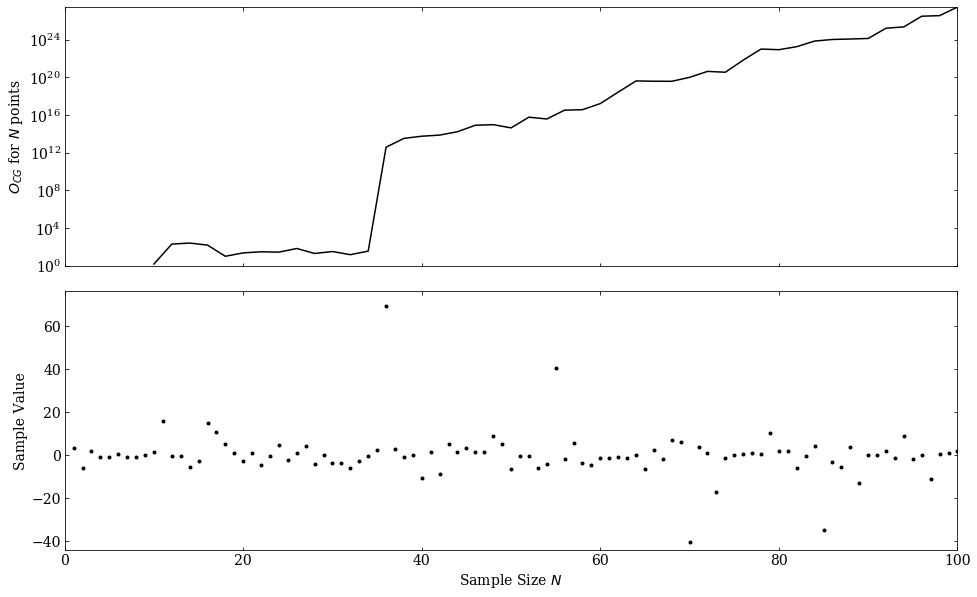

In [7]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import cauchy, norm
from scipy import integrate

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=False)


def logL_cauchy(xi, gamma, mu,
                mu_min=-10, mu_max=10, sigma_min=0.01, sigma_max=100):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(gamma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    prior_normalization = - (np.log(mu_max - mu_min)
                             + np.log(np.log(sigma_max / sigma_min)))

    return (prior_normalization
            - n * np.log(np.pi)
            + (n - 1) * np.log(gamma)
            - np.sum(np.log(gamma ** 2 + (xi - mu) ** 2), 0))


def logL_gaussian(xi, sigma, mu,
                  mu_min=-10, mu_max=10, sigma_min=0.01, sigma_max=100):
    """Equation 5.57: gaussian likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    prior_normalization = - (np.log(mu_max - mu_min)
                             + np.log(np.log(sigma_max / sigma_min)))

    return (prior_normalization
            - 0.5 * n * np.log(2 * np.pi)
            - (n + 1) * np.log(sigma)
            - np.sum(0.5 * ((xi - mu) / sigma) ** 2, 0))


def calculate_odds_ratio(xi, epsrel=1E-8, epsabs=1E-15):
    """
    Compute the odds ratio by perfoming a double integral
    over the likelihood space.
    """
    gauss_Ifunc = lambda mu, sigma: np.exp(logL_gaussian(xi, mu, sigma))
    cauchy_Ifunc = lambda mu, gamma: np.exp(logL_cauchy(xi, mu, gamma))

    I_gauss, err_gauss = integrate.dblquad(gauss_Ifunc, -np.inf, np.inf,
                                           lambda x: 0, lambda x: np.inf,
                                           epsabs=epsabs, epsrel=epsrel)
    I_cauchy, err_cauchy = integrate.dblquad(cauchy_Ifunc, -np.inf, np.inf,
                                             lambda x: 0, lambda x: np.inf,
                                             epsabs=epsabs, epsrel=epsrel)

    if I_gauss == 0:
        O_CG = np.inf
        err_O_CG = np.inf
    else:
        O_CG = I_cauchy / I_gauss
        err_O_CG = O_CG * np.sqrt((err_gauss / I_gauss) ** 2)

    return (I_gauss, err_gauss), (I_cauchy, err_cauchy), (O_CG, err_O_CG)


#------------------------------------------------------------
# Draw points from a Cauchy distribution
np.random.seed(44)
mu = 0
gamma = 2
xi = cauchy(mu, gamma).rvs(100)

#------------------------------------------------------------
# compute the odds ratio for the first 10 points
((I_gauss, err_gauss),
 (I_cauchy, err_cauchy),
 (O_CG, err_O_CG)) = calculate_odds_ratio(xi[:10])

print ("Results for first 10 points:")
print ("  L(M = Cauchy) = %.2e +/- %.2e" % (I_cauchy, err_cauchy))
print ("  L(M = Gauss)  = %.2e +/- %.2e" % (I_gauss, err_gauss))
print ("  O_{CG} = %.3g +/- %.3g" % (O_CG, err_O_CG))

#------------------------------------------------------------
# calculate the results as a function of number of points
Nrange = np.arange(10, 101, 2)
Odds = np.zeros(Nrange.shape)
for i, N in enumerate(Nrange):
    res = calculate_odds_ratio(xi[:N])
    Odds[i] = res[2][0]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(16, 10))
fig.subplots_adjust(hspace=0.1)

ax1 = fig.add_subplot(211, yscale='log')
ax1.plot(Nrange, Odds, '-k')
ax1.set_ylabel(r'$O_{CG}$ for $N$ points')
ax1.set_xlim(0, 100)
ax1.set_ylim(1, Odds.max()*1.1)
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_locator(plt.LogLocator(base=10000.0))

ax2 = fig.add_subplot(212)
ax2.scatter(np.arange(1, len(xi) + 1), xi, lw=0, s=16, c='k')
ax2.set_xlim(0, 100)
ax2.set_ylim(xi.min()*1.1, xi.max()*1.1)
ax2.set_xlabel('Sample Size $N$')
ax2.set_ylabel('Sample Value')

plt.show() 


The odds ratio for the first 10 points is very close to unity ($O_{CG} = 1.45$) and 
is therefore inconclusive.
 
Why do we get an inconclusive odds ratio? With only 10 points, the probability of 
drawing at least one point far away from the mean, which would strongly argue against 
the Gaussian model, is fairly small. As the number of data values is increased, the 
ability to discriminate between the models increases, too. As the above figure shows,
when we increase the size of the observed sample, the odds ratio quickly favors the 
Cauchy over the Gaussian model.

## Practical (Computational) Problems

Going back to our polynomial example, we could use the same method and 
integrate (marginalize) the posterior over model parameter space $\theta$.

However, the data likelihood in that example can become cumbersome to track
(for the cubic fit, it's a 4-dimensional space to integrate!) and it's much
easier to compare the fits using numerical methods such as Markov Chain
Monte Carlo (MCMC).

We'll introduce MCMC next week (and apply it to this example, too). 

Meanwhile, let's introduce an approximate method for model comparison.

### Approximate Bayesian Model Comparison

### Bayesian Information Criterion
A common scoring system is the **Bayesian information criterion (BIC)**. It can 
be derived from the model odds ratio by assuming that the data likelihood is 
Gaussian (see $\S$5.4.2 in textbook for details). The BIC is easier to compute 
than the model odds ratio because it only depends on the maximum value of the data 
likelihood, $L_0(M)$. For $N$ data points and a model 
with $k$ parameters:

$${\rm BIC} \equiv -2 \ln [L_0(M)] + k \ln N$$ 

Interpretation: the 1st term is equal to model's $\chi^2$ (if the model was Gaussian); the 2nd term penalizes complex models relative to simple ones.

### Aikake Information Criterion

Another well-known scoring system is the **Aikake information criterion (AIC)**,  computed as

$${\rm AIC} \equiv -2 \ln [L_0(M)] + 2k + \frac{2k(k+1)}{N-k-1}.$$

This comes from information theory considerations -- if you think of modeling as "lossy compression", which model loses less data? We won't discuss it in great detail here, but see the textbook if you're curious.

When two models are compared, their BIC (or AIC) are compared analogously to the 
odds ratio, that is, the model with the smaller value wins. If the models are 
equally successful in describing the data (i.e., they have the same value of $L_0(M)$), 
then the model with fewer free parameters wins. Note: sometimes BIC and AIC are defined using the ***opposite*** sign, in which case the model with the largest value wins!

***Both the BIC and AIC are approximations and might not be valid if the underlying 
assumptions are not met***. Furthermore, unlike the odds ratio, both of them penalize 
unconstrained parameters. In general, it is better to compute the odds ratio when 
computationally feasible. 

Let's us BIC to choose the best polynomial from the earlier line fitting example. 
Starting with

$${\rm BIC} = \chi^2 + k \ln N,$$ 

with $N=20$ we have:

<pre>
     model     chi2    k   k*ln(N)   BIC       
    linear    11.32    2    5.99    17.31   
  quadratic    9.46    3    8.99    18.45   
     cubic     8.99    4   11.98    20.97  
</pre>

Therefore, the improvement in $\chi^2$ for the quadratic model, relative 
to the linear model, **is not large enough to justify another free model
parameter.** 

### Cross-validation

Another useful method for model selection is the **cross-validation method**.
Its disadvantage is that it may be computationally intensive for complex
problems, but its great advantage is that it is conceptually simple and
easy to implement (for details see textbook, Section 8.11.1). The basic idea of 
the cross-validation method is to set aside a fraction of the sample when
obtaining the best-fit parameters and then compute the goodness-of-fit 
(e.g. $\chi^2$, but any metric can be implemented) with this unused subsample. 
The "leave-one-out" implementation repeats model fitting $N$ times, using
$N-1$ data points. Each time the missing point is used to compute the 
goodness-of-fit, and the $N$ values are averaged. 

When the model is too simple, it will have high bias (under-fitting)
and when the model is too complex, the variance will be high (over-fitting).


![BayesSlide1](figures/fig8-13.jpg)

This concludes our introduction to Bayesian inference and model comparison!

We now know how to:
* Interpret probability as quantified knowledge (degree of belief)
* Select priors
* Update our knowledge given new data
* Compare and select models

We've also noticed a problem: Bayesian inference doesn't result in just "best fit" values, but full probability density functions, and sometime highly dimensional ones. This results in computational challenges, which we'll tackle next with Markov Chain Monte Carlo.